In [1]:
import warnings
warnings.simplefilter('ignore', FutureWarning)  # FutureWarningを消している

In [2]:
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
import networkx as nx

In [3]:
# 渋谷駅（スクランブル交差点）
shibuya_eki = 35.65952515598417, 139.70055390184527
# HENGE
henge = 35.65495728145334, 139.69494603459512


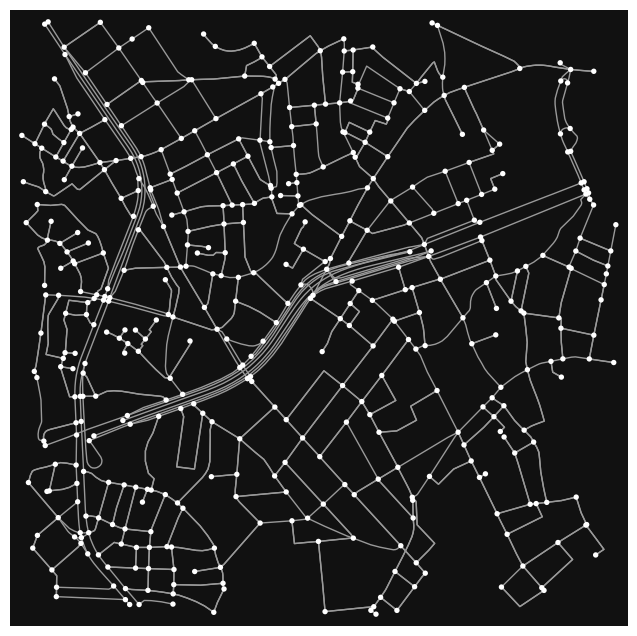

In [41]:
# HENGEを中心とした半径600mの地図を表示
dist = 600  # meters
G = ox.graph_from_point(henge, dist, network_type="drive")
fig, ax = ox.plot_graph(G)

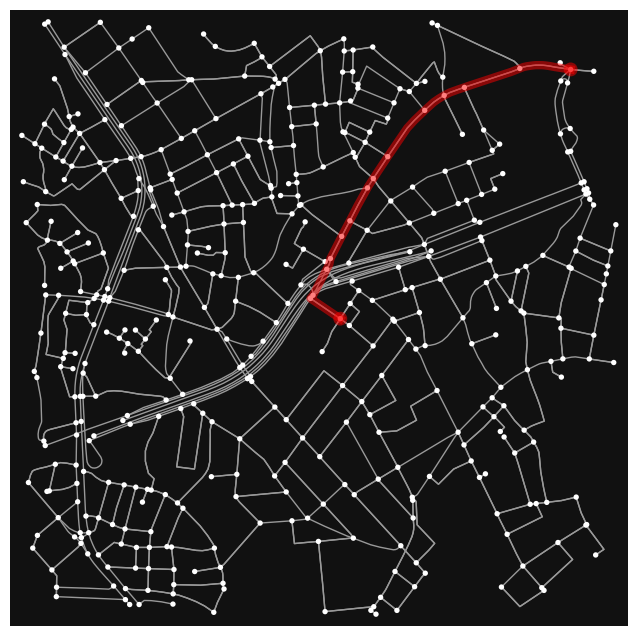

In [40]:
# 渋谷駅からHENGEまでの最短距離
start_node = ox.distance.nearest_nodes(G, shibuya_eki[1], shibuya_eki[0])
end_node = ox.distance.nearest_nodes(G, henge[1], henge[0])

route1 = ox.shortest_path(G, start_node, end_node)  # 最短経路を取得
fig, ax = ox.plot_graph_route(G, route1, route_color='r', route_linewidth=6) # ルートを表示

In [6]:
# 神泉駅
shinsen = 35.65775285967325, 139.69353293448464

In [42]:
# # HENGEを中心とした半径500mの地図を表示
# dist = 500  # meters
# G = ox.graph_from_point(henge, dist, network_type="drive")
# fig, ax = ox.plot_graph(G)

In [43]:
# ある地点からある地点までの最短ルートを取得
def get_shortest_routes(G, start1, start2, end1, end2):
    start_node = ox.distance.nearest_nodes(G, start1, start2)
    end_node = ox.distance.nearest_nodes(G, end1, end2)
    
    return ox.shortest_path(G, start_node, end_node)  # 最短経路を取得

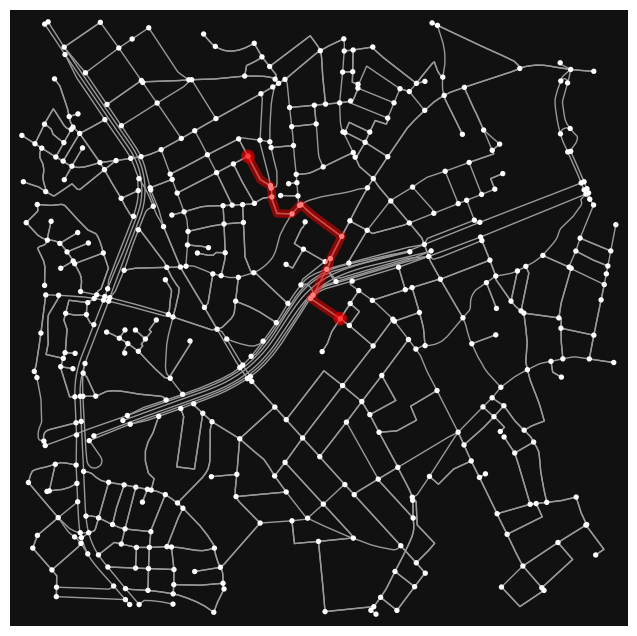

In [44]:
# 神泉駅からHENGEまでの最短距離
route2 = get_shortest_routes(G, shinsen[1], shinsen[0], henge[1], henge[0])
fig, ax = ox.plot_graph_route(G, route2, route_color='r', route_linewidth=6) # ルートを表示

In [20]:
route2

[381088629,
 381089764,
 381091881,
 381091890,
 1496233505,
 1014529451,
 12142447651,
 1014529833,
 356644779,
 381063833,
 625566390,
 748883733,
 748883764]

In [21]:
import pyproj

def calculate_bearing(lat1, lon1, lat2, lon2):
    """
    2点間の方位角（北から時計回りの角度）を計算する関数
    """
    grs80 = pyproj.Geod(ellps='GRS80')  # GRS80楕円体
    azimuth, bkw_azimuth, distance = grs80.inv(lon1, lat1, lon2, lat2)
    return azimuth

In [22]:
def set_routing_info(G, route):
    lat = []
    lon = []
    bear = []
    if route:
        for route_id in route:
            lat.append(G.nodes[route_id]['y'])  # 経度
            lon.append(G.nodes[route_id]['x'])  # 緯度

    if lat and len(lat) > 0:
        for i in range(0, len(lat) - 1):
            # print(i)
            bear.append(calculate_bearing(lat[i], lon[i], lat[i + 1], lon[i + 1]))
    
    return lat, lon, bear

In [31]:
def check_right(bear, route):
    if len(bear) > 2:
        for i in range(0, len(bear) - 1):
            bear_diff = bear[i + 1] - bear[i]
            if (270 < bear_diff < 360) or (-90 < bear_diff < 0):
                print(i, route[i], "右折", bear_diff)
                return i
            else:
                print(i, route[i], "右折以外", bear_diff)
    return -1

In [35]:
def check_naighbors(G, new_route, i, end_node, depth, del_node=[]):
    # print("++++++++++++++++++++++++++++++++++++++++++++++++++")
    # print("子 check_naighbors", i, "深さ=", depth)
    # print("子 new_route=", len(new_route), new_route)
    # print("子 del_node=", len(del_node), del_node)
    if depth > 100:
        print("深すぎ")
        return -1
    try:
        # 前後のノードを削除対象にする
        del_node.append(new_route[i + 1])
        del_node.append(new_route[i - 1])
    except:
        pass
    # 右折のノードから別のノードへ移動できないか確認
    g1 = nx.Graph(G)  # 無向グラフに変換
    # 隣り合うノードを取得
    node_neighbors = list(nx.all_neighbors(g1, new_route[i]))

    # 前後のノード以外に移動先がある（前後のノードは削除）
    try:
        for dn in del_node:
            if dn in node_neighbors:
                node_neighbors.remove(dn)
    except:
        pass
    # print("len(node_neighbors)=", len(node_neighbors))
    
    if len(node_neighbors) > 0:
        
        # for nei in node_neighbors:  # 隣り合うノード分繰り返す
        #     print("nei=", nei)
        nei = node_neighbors[0]
        print("nei=", nei)
        # 新しいノードから、ゴールまでの最短経路を求める
        new_route2 = ox.shortest_path(G, nei, end_node)  # 最短経路を取得
        if not new_route2:
            print("失敗、終了")
            return -1
        lat2, lon2, bear2 = set_routing_info(G, new_route2)
        # print("new_route2=", new_route2)
        res2 = check_right(bear2, new_route2)
        if res2 < 0:
            # 最後まで右折が無かったら、終了
            print("子 成功!!")
            return new_route[:(i + 1)] + new_route2
        elif res2 == 0:
            # 最初が右折だったら、ひとつ前に戻る
            print("最初が右折だった")
        else:
            # 途中で右折があった
            print("右折があった", res2)
            try:
                del_node.append(new_route2[res2 - 1])
                del_node.append(new_route2[res2 + 1])
            except:
                pass
            tmp_route = check_naighbors(G, new_route2, res2, end_node, depth + 1, del_node)
            # if tmp_route == -1:
            #     continue
            # else:
            #     return new_route2[:(res2 + 1)] + tmp_route
            if tmp_route != -1:
                 return new_route2[:(res2 + 1)] + tmp_route

        # ======もとのfor文 ここまで
        # 全部の隣のノードで失敗した（ひとつ前のノードに戻る）
        # print("全部の隣のノードで失敗した")
        if i - 1 < 0:
            print("失敗、終了")
            return -1
        # ひとつ前に戻れたら戻る
        tmp_route = check_naighbors(G, new_route, i - 1 , end_node, 0, del_node)
        if tmp_route == -1:
            print("失敗、終了")
            return -1
        return tmp_route
    else:
        # 移動先がない（ひとつ前のノードに戻る）
        print("移動先がない")
        if i - 1 < 0:
            print("失敗、終了")
            return -1
        # ひとつ前に戻れたら戻る
        tmp_route = check_naighbors(G, new_route, i - 1, end_node, 0, del_node)
        if tmp_route == -1:
            print("失敗、終了")
            return -1
        return tmp_route
    print("失敗、終了")
    return -1

In [36]:
# 渋谷駅からHENGEまでの最短距離
start_node = ox.distance.nearest_nodes(G, shinsen[1], shinsen[0])
end_node = ox.distance.nearest_nodes(G, henge[1], henge[0])

new_route = ox.shortest_path(G, start_node, end_node)  # 最短経路を取得
lat, lon, bear = set_routing_info(G, new_route)

# print(lat, len(lat))
# print(lon, len(lon))
# print(bear, len(bear))


print("new_route=",new_route)
res = check_right(bear, new_route)
print("親 res=", res, len(new_route) - 1)
if res < 0:
    print("成功！")
else:
    # 途中で右折があった
    del_node = [new_route[res - 1], new_route[res + 1]]
    new_route2 = check_naighbors(G, new_route, res, end_node, 0, del_node)
    print("親 new_route=", new_route2)
    if new_route2 == -1:
        print("親、失敗")
    else:
        new_route = new_route2[:]

new_route= [381088629, 381089764, 381091881, 381091890, 1496233505, 1014529451, 12142447651, 1014529833, 356644779, 381063833, 625566390, 748883733, 748883764]
0 381088629 右折以外 23.414986245147645
1 381089764 右折以外 9.525154302932037
2 381091881 右折 -45.38402698689217
親 res= 2 12
nei= 1497985602
0 1497985602 右折以外 89.70833239776758
1 1497985610 右折以外 0.8216491884082302
2 1014529376 右折 -0.013737690214895792
右折があった 2
nei= 1497320043
0 1497320043 右折 280.7248338720202
最初が右折だった
nei= 1211660881
0 1211660881 右折 -0.08323505907338813
最初が右折だった
nei= 381091881
0 381091881 右折 -45.38402698689217
最初が右折だった
失敗、終了
失敗、終了
失敗、終了
nei= 1496865251
0 1496865251 右折 -1.0556518751116357
最初が右折だった
nei= 381088628
0 381088628 右折以外 -247.7474923051982
1 597722265 右折 273.36750519927136
右折があった 1
移動先がない
nei= 597722044
0 597722044 右折 -67.03405669935387
最初が右折だった
失敗、終了
失敗、終了
失敗、終了
失敗、終了
失敗、終了
親 new_route= -1
親、失敗


new_route_end= [381088629, 381089764, 381091881, 381091890, 1496233505, 1014529451, 12142447651, 1014529833, 356644779, 381063833, 625566390, 748883733, 748883764]


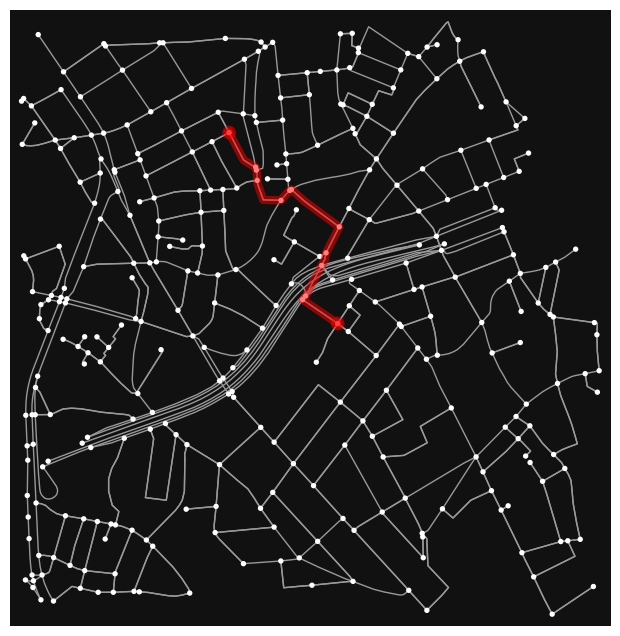

In [34]:
# new_route= [12142447651, 1014529833, 356644779, 381063833, 625566390, 748883733, 748883764]
print("new_route_end=", new_route)        
fig, ax = ox.plot_graph_route(G, new_route, route_color='r', route_linewidth=6) # ルートを表示